In [24]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd.functional import hessian

from aeons.likelihoods import full
from aeons.covariance import X_mu
from aeons.true_distribution import nk_dead_live, generate_Xs
from aeons.lm_partial import sigma_squared_analytic, logLmax_analytic

In [104]:
def sigma_squared_analytic(d, X_i, logL_i):
    """Sigma squared as a function of d and the live points at a certain iteration i"""
    n = len(X_i)
    logsum = torch.sum(logL_i)
    sum_X_4d = torch.sum(X_i**(4/d))
    sum_X_2d = torch.sum(X_i**(2/d))
    sum_log_X_2d = torch.sum(X_i**(2/d) * logL_i)
    numerator = n * sum_X_4d - sum_X_2d**2
    denominator = 2 * logsum * sum_X_2d - 2*n*sum_log_X_2d
    return numerator/denominator

def logLmax_analytic(d, X_i, logL_i):
    """Returns logLmax as a function of d and the live points at a certain iteration i"""
    n = len(X_i)
    logsum = torch.sum(logL_i)
    sum_X_2d = torch.sum(X_i**(2/d))
    return 1/n * logsum + 1/(2*n*sigma_squared_analytic(d, X_i, logL_i)) * sum_X_2d

def hessian_d(logL, X, d):
    d = torch.tensor(float(d))
    logL = torch.tensor(logL)
    X = torch.tensor(X)
    def logL_loss(d):
        logLmax = logLmax_analytic(d, X, logL)
        sigma_squared = sigma_squared_analytic(d, X, logL)
        loss = logL - ( logLmax - (X**(2/d)) / (2 * sigma_squared) )
        return torch.sum(loss**2)
    return hessian(logL_loss, d)

def logL_loss(logL, X, d):
    d = torch.tensor(float(d))
    logL = torch.tensor(logL)
    X = torch.tensor(X)
    logLmax = logLmax_analytic(d, X, logL)
    sigma_squared = sigma_squared_analytic(d, X, logL)
    loss = logL - ( logLmax - (X**(2/d)) / (2 * sigma_squared) )
    return torch.sum(loss**2)

In [111]:
# Synthetic data
nk = nk_dead_live(nlive=100, ndead=200)
mean_X = X_mu(nk)
theta_true = [5, 20, 0.001]
logL = full.func(mean_X, theta_true)

In [128]:
ds = np.linspace(5, 200, 100)
losses = torch.tensor([logL_loss(logL, mean_X, d) for d in ds])
hessians = torch.tensor([hessian_d(logL, mean_X, d) for d in ds])

(-1000000.0, 1000000.0)

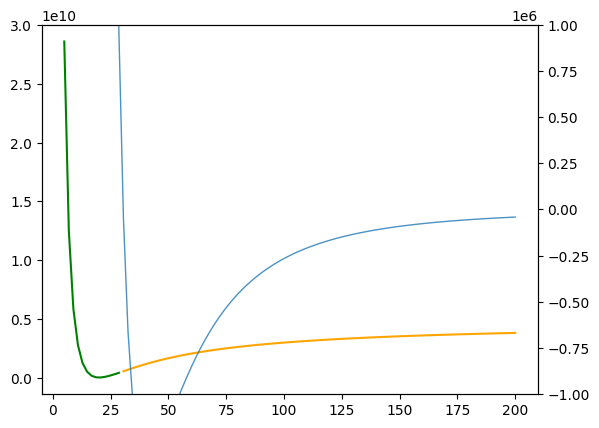

In [143]:
fig, ax = plt.subplots()
ax1 = plt.twinx(ax)

pos_indices = hessians > 0
neg_indices = hessians < 0
ds_pos = ds[pos_indices]
ds_neg = ds[neg_indices]
losses_pos = losses[pos_indices]
losses_neg = losses[neg_indices]

ax.plot(ds_pos, losses_pos, color='green')
ax.plot(ds_neg, losses_neg, color='orange')
ax1.plot(ds, hessians, lw=1, alpha=0.8)
ax1.set_ylim(-1e6, 1e6)